In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 23 00:26:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install peft
!pip install evaluate
!pip install iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.4 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/datos/
import pandas as pd

df = pd.read_csv('ensayos_2.csv', sep = ";", encoding="ISO-8859-1")
cols = df.columns
label_cols = list(cols[2:])
num_labels = len(label_cols)
df['one_hot_labels'] = list(df[label_cols].values)
df = df.sample(frac=1).reset_index(drop=True) #barajar filas
df.head()

Mounted at /gdrive
/gdrive/MyDrive/datos


,ï»¿ID,TEXT,EXT,NEU,OPN,one_hot_labels
0,1997_512804.txt,I am at work right now but I donât start to ...,0,1,0,"[0, 1, 0]"
1,2000_618192.txt,I would guess the only thoughts in my head rig...,1,0,0,"[1, 0, 0]"
2,1998_535096.txt,It started out kind of good because school had...,0,1,1,"[0, 1, 1]"
3,1999_937378.txt,The Complete Works of Shakespere is a very lar...,1,0,1,"[1, 0, 1]"
4,1997_881327.txt,Well right now I have to go to the bathroom bu...,0,1,0,"[0, 1, 0]"


In [5]:
import argparse
import os
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)

import evaluate
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from datasets import Dataset
import torch
import numpy as np
import random
import torch
from torch.nn import BCEWithLogitsLoss
from tqdm import trange
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import roc_auc_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
from transformers import RobertaForSequenceClassification
from torch.optim import Adam, Adagrad
from transformers import RobertaTokenizer

In [6]:
cols = df.columns
df = df.sample(frac=1).reset_index(drop=True) #barajar filas
df.head()

,ï»¿ID,TEXT,EXT,NEU,OPN,one_hot_labels
0,1998_899161.txt,I just waited 45 minutes for a bus to come and...,0,1,1,"[0, 1, 1]"
1,2002_991230.txt,I am really tired. I got up this morning at 7:...,0,0,1,"[0, 0, 1]"
2,1997_893217.txt,the end of this song is so weird. what was And...,1,0,1,"[1, 0, 1]"
3,2000_991293.txt,"This assignment seemed so easy at first, but n...",0,1,0,"[0, 1, 0]"
4,1997_790253.txt,I am very excited to be taking this psychology...,0,1,1,"[0, 1, 1]"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2467 entries, 0 to 2466
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ï»¿ID           2467 non-null   object
 1   TEXT            2467 non-null   object
 2   EXT             2467 non-null   int64 
 3   NEU             2467 non-null   int64 
 4   OPN             2467 non-null   int64 
 5   one_hot_labels  2467 non-null   object
dtypes: int64(3), object(3)
memory usage: 115.8+ KB


In [8]:
#configuracion previa (ajuste loRA)
model_name_or_path = "roberta-large"
peft_type = PeftType.LORA
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1)
# Define el nombre de las columnas del dataset
column_names = ['TEXT', 'EXT', 'NEU', 'OPN', 'one_hot_labels']

# Convertir el dataframe en un diccionario
data = {
    column: df[column].tolist()
    for column in column_names
}

# Crear el dataset de Hugging Face
dataset = Dataset.from_dict(data)

if any(k in model_name_or_path for k in ("gpt", "opt", "bloom")):
    padding_side = "left"
else:
    padding_side = "right"

In [9]:
#tokenizacion
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
def tokenize_function(examples):
        outputs = tokenizer(examples["TEXT"], truncation=True, max_length=512)
        return outputs
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["TEXT", "EXT", "NEU", "OPN"],
)
tokenized_datasets = tokenized_datasets.rename_column("one_hot_labels", "labels")
def collate_fn(examples):
    return tokenizer.pad(examples, padding='longest', return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

Map:   0%|          | 0/2467 [00:00<?, ? examples/s]

Fold: 1/5
Train index: [   1    2    3 ... 2462 2465 2466]
Eval index: [   0    7   18   21   26   32   33   40   42   43   50   74   75   76
   80   90   95   97  107  111  129  135  142  148  149  153  157  159
  163  164  169  174  176  181  184  188  190  191  198  201  202  209
  220  227  241  253  255  257  260  261  274  279  281  285  291  295
  296  302  303  304  306  322  325  326  331  334  338  339  342  344
  347  350  356  360  362  369  373  375  376  379  382  391  393  396
  398  400  404  408  422  423  430  432  436  437  450  461  467  469
  471  472  473  482  485  512  514  515  519  521  523  526  531  532
  534  554  555  556  576  578  582  586  590  591  593  597  599  603
  614  616  617  618  633  648  650  651  658  659  663  670  671  673
  678  679  686  691  695  699  700  701  705  711  720  728  734  741
  742  743  745  747  755  763  768  778  779  784  794  795  814  824
  826  827  830  832  840  848  850  859  861  865  868  872  873  874
  894 

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683
Epoch: 1/4
Train Loss: 0.7006
Eval Loss: 0.6880
AUC: 0.6048
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       256
           1       0.51      0.96      0.67       247
           2       0.54      0.92      0.68       255

   micro avg       0.53      0.63      0.57       758
   macro avg       0.52      0.63      0.45       758
weighted avg       0.52      0.63      0.45       758
 samples avg       0.52      0.55      0.51       758



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6803
Eval Loss: 0.6669
AUC: 0.6380
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       256
           1       0.62      0.44      0.52       247
           2       0.77      0.40      0.53       255

   micro avg       0.63      0.52      0.57       758
   macro avg       0.66      0.52      0.56       758
weighted avg       0.66      0.52      0.56       758
 samples avg       0.54      0.47      0.46       758



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6504
Eval Loss: 0.6566
AUC: 0.6495
              precision    recall  f1-score   support

           0       0.59      0.71      0.64       256
           1       0.57      0.62      0.60       247
           2       0.70      0.56      0.63       255

   micro avg       0.61      0.63      0.62       758
   macro avg       0.62      0.63      0.62       758
weighted avg       0.62      0.63      0.62       758
 samples avg       0.57      0.56      0.52       758



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6220
Eval Loss: 0.6666
AUC: 0.6528
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       256
           1       0.56      0.51      0.53       247
           2       0.71      0.55      0.62       255

   micro avg       0.62      0.59      0.60       758
   macro avg       0.63      0.59      0.60       758
weighted avg       0.63      0.59      0.60       758
 samples avg       0.55      0.52      0.50       758

Fold: 2/5
Train index: [   0    1    3 ... 2462 2463 2464]
Eval index: [   2    8   12   14   16   19   23   31   37   46   49   51   52   54
   58   71   82   89   98  106  108  109  115  121  126  131  133  139
  140  144  146  162  166  168  171  173  177  179  182  192  193  196
  197  200  205  210  217  221  230  237  247  249  264  268  280  290
  293  307  313  315  318  320  321  324  333  340  345  351  359  377
  378  381  384  385  395  402  405  406  412  415  424  426  428  429
  440  4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683
Epoch: 1/4
Train Loss: 0.7022
Eval Loss: 0.6799
AUC: 0.6252
              precision    recall  f1-score   support

           0       0.63      0.42      0.50       255
           1       0.51      0.96      0.67       247
           2       0.64      0.59      0.61       254

   micro avg       0.57      0.65      0.61       756
   macro avg       0.60      0.66      0.60       756
weighted avg       0.60      0.65      0.59       756
 samples avg       0.56      0.61      0.55       756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6757
Eval Loss: 0.6849
AUC: 0.6537
              precision    recall  f1-score   support

           0       0.54      0.96      0.70       255
           1       0.67      0.18      0.28       247
           2       0.75      0.31      0.44       254

   micro avg       0.59      0.49      0.54       756
   macro avg       0.65      0.48      0.47       756
weighted avg       0.65      0.49      0.48       756
 samples avg       0.57      0.45      0.47       756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6424
Eval Loss: 0.6580
AUC: 0.6632
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       255
           1       0.58      0.60      0.59       247
           2       0.74      0.52      0.61       254

   micro avg       0.64      0.62      0.63       756
   macro avg       0.65      0.62      0.63       756
weighted avg       0.65      0.62      0.63       756
 samples avg       0.60      0.57      0.55       756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6131
Eval Loss: 0.6692
AUC: 0.6613
              precision    recall  f1-score   support

           0       0.65      0.64      0.64       255
           1       0.57      0.62      0.59       247
           2       0.74      0.55      0.63       254

   micro avg       0.64      0.60      0.62       756
   macro avg       0.65      0.60      0.62       756
weighted avg       0.65      0.60      0.62       756
 samples avg       0.59      0.55      0.53       756

Fold: 3/5
Train index: [   0    2    3 ... 2464 2465 2466]
Eval index: [   1    5    6   10   13   15   27   29   30   35   39   44   48   56
   59   64   65   69   79   83   86   87   94  101  103  113  124  137
  141  143  151  160  187  194  211  213  214  216  218  219  223  229
  231  232  233  242  248  251  252  254  258  262  267  271  275  277
  287  288  289  298  300  314  316  317  323  327  332  337  349  361
  364  365  366  368  374  380  388  397  399  407  411  416  417  421
  427  4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683
Epoch: 1/4
Train Loss: 0.7058
Eval Loss: 0.6855
AUC: 0.6314
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       255
           1       0.51      0.93      0.66       246
           2       0.54      0.96      0.69       254

   micro avg       0.52      0.97      0.68       755
   macro avg       0.52      0.97      0.68       755
weighted avg       0.52      0.97      0.68       755
 samples avg       0.52      0.89      0.63       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6859
Eval Loss: 0.6601
AUC: 0.6587
              precision    recall  f1-score   support

           0       0.59      0.75      0.66       255
           1       0.59      0.54      0.56       246
           2       0.67      0.61      0.64       254

   micro avg       0.62      0.63      0.62       755
   macro avg       0.62      0.63      0.62       755
weighted avg       0.62      0.63      0.62       755
 samples avg       0.58      0.59      0.55       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6478
Eval Loss: 0.6555
AUC: 0.6672
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       255
           1       0.60      0.62      0.61       246
           2       0.74      0.46      0.57       254

   micro avg       0.63      0.59      0.61       755
   macro avg       0.65      0.59      0.61       755
weighted avg       0.65      0.59      0.61       755
 samples avg       0.54      0.55      0.51       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6158
Eval Loss: 0.6617
AUC: 0.6649
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       255
           1       0.62      0.61      0.61       246
           2       0.75      0.46      0.57       254

   micro avg       0.65      0.55      0.60       755
   macro avg       0.66      0.56      0.60       755
weighted avg       0.66      0.55      0.60       755
 samples avg       0.54      0.52      0.50       755

Fold: 4/5
Train index: [   0    1    2 ... 2464 2465 2466]
Eval index: [   3    4    9   22   24   25   28   34   41   45   53   55   62   63
   73   78   85   88   92   93   96  105  112  116  117  122  125  132
  134  136  138  152  154  158  161  167  170  172  175  178  180  183
  186  199  203  204  206  208  212  215  224  228  234  235  236  238
  239  243  245  259  263  270  272  278  283  284  299  301  310  328
  336  341  348  352  353  355  358  363  370  386  390  413  419  420
  425  4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683
Epoch: 1/4
Train Loss: 0.7032
Eval Loss: 0.6815
AUC: 0.6192
              precision    recall  f1-score   support

           0       0.53      0.94      0.68       255
           1       0.61      0.32      0.42       247
           2       0.65      0.50      0.57       254

   micro avg       0.57      0.59      0.58       756
   macro avg       0.60      0.59      0.56       756
weighted avg       0.60      0.59      0.56       756
 samples avg       0.57      0.52      0.51       756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6769
Eval Loss: 0.6704
AUC: 0.6479
              precision    recall  f1-score   support

           0       0.56      0.81      0.66       255
           1       0.56      0.88      0.68       247
           2       0.57      0.83      0.68       254

   micro avg       0.56      0.84      0.67       756
   macro avg       0.56      0.84      0.67       756
weighted avg       0.56      0.84      0.67       756
 samples avg       0.56      0.75      0.61       756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6444
Eval Loss: 0.6694
AUC: 0.6453
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       255
           1       0.64      0.37      0.47       247
           2       0.61      0.71      0.65       254

   micro avg       0.61      0.56      0.59       756
   macro avg       0.61      0.56      0.57       756
weighted avg       0.61      0.56      0.58       756
 samples avg       0.55      0.49      0.49       756



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6052
Eval Loss: 0.6758
AUC: 0.6462
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       255
           1       0.61      0.61      0.61       247
           2       0.67      0.54      0.60       254

   micro avg       0.62      0.60      0.61       756
   macro avg       0.63      0.60      0.61       756
weighted avg       0.63      0.60      0.61       756
 samples avg       0.56      0.54      0.52       756

Fold: 5/5
Train index: [   0    1    2 ... 2464 2465 2466]
Eval index: [  11   17   20   36   38   47   57   60   61   66   67   68   70   72
   77   81   84   91   99  100  102  104  110  114  118  119  120  123
  127  128  130  145  147  150  155  156  165  185  189  195  207  222
  225  226  240  244  246  250  256  265  266  269  273  276  282  286
  292  294  297  305  308  309  311  312  319  329  330  335  343  346
  354  357  367  371  372  383  387  389  392  394  401  403  409  410
  414  4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,839,107 || all params: 357,201,926 || trainable%: 0.5148648050682683
Epoch: 1/4
Train Loss: 0.7013
Eval Loss: 0.6893
AUC: 0.6184
              precision    recall  f1-score   support

           0       0.57      0.50      0.54       255
           1       0.00      0.00      0.00       246
           2       0.69      0.40      0.51       254

   micro avg       0.62      0.30      0.41       755
   macro avg       0.42      0.30      0.35       755
weighted avg       0.43      0.30      0.35       755
 samples avg       0.41      0.27      0.31       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/4
Train Loss: 0.6790
Eval Loss: 0.6579
AUC: 0.6575
              precision    recall  f1-score   support

           0       0.55      0.85      0.67       255
           1       0.61      0.51      0.56       246
           2       0.66      0.65      0.66       254

   micro avg       0.60      0.67      0.64       755
   macro avg       0.61      0.67      0.63       755
weighted avg       0.61      0.67      0.63       755
 samples avg       0.58      0.61      0.55       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/4
Train Loss: 0.6401
Eval Loss: 0.6630
AUC: 0.6642
              precision    recall  f1-score   support

           0       0.68      0.36      0.47       255
           1       0.59      0.75      0.66       246
           2       0.70      0.51      0.59       254

   micro avg       0.64      0.54      0.58       755
   macro avg       0.66      0.54      0.57       755
weighted avg       0.66      0.54      0.57       755
 samples avg       0.54      0.49      0.49       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/4
Train Loss: 0.6096
Eval Loss: 0.6718
AUC: 0.6626
              precision    recall  f1-score   support

           0       0.59      0.68      0.63       255
           1       0.63      0.51      0.56       246
           2       0.70      0.52      0.59       254

   micro avg       0.63      0.57      0.60       755
   macro avg       0.64      0.57      0.60       755
weighted avg       0.64      0.57      0.60       755
 samples avg       0.56      0.52      0.51       755



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


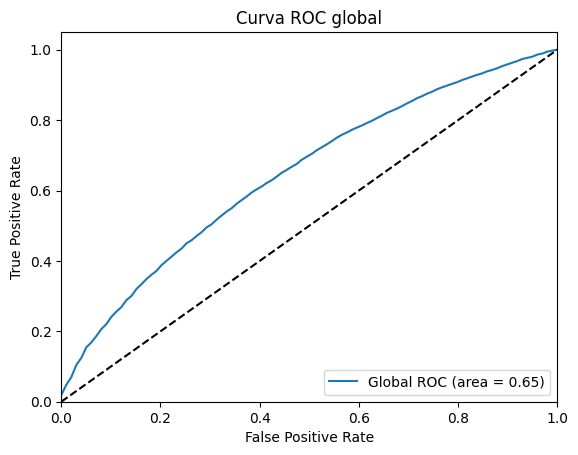

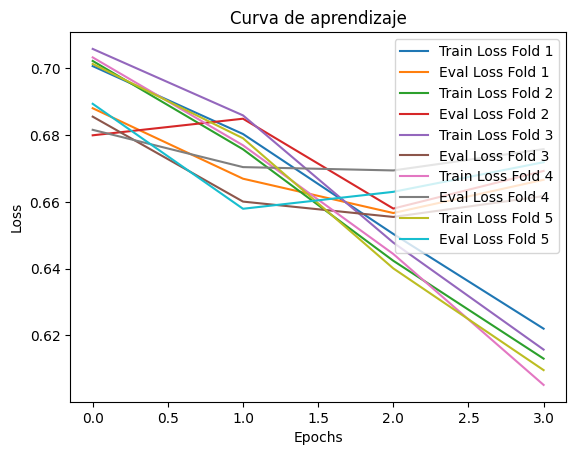

In [10]:
k = 5
kf = MultilabelStratifiedKFold(n_splits=k, shuffle=True, random_state=42)

X = tokenized_datasets["input_ids"]
y = tokenized_datasets["labels"]

all_fpr = []
all_tpr = []
all_roc_auc = []

train_losses = []
eval_losses = []

for fold, (train_index, eval_index) in enumerate(kf.split(X, y)):
    print(f'Fold: {fold + 1}/{k}')
    print(f'Train index: {train_index}')
    print(f'Eval index: {eval_index}')
    device = "cuda"
    num_epochs = 4
    batch_size = 1
    lr = 5e-5
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    num_labels=3
    model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=num_labels)
    model.task_name = "classification"
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    model.cuda()
    train_dataset = tokenized_datasets.select(train_index)
    eval_dataset = tokenized_datasets.select(eval_index)
    train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
    eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn, batch_size=batch_size)

    # Optimizador
    # Definir el optimizador como Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Instantiate scheduler
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0.06 * (len(train_dataloader) * num_epochs),
        num_training_steps=(len(train_dataloader) * num_epochs),
    )

    epoch_train_losses = []
    epoch_eval_losses = []


    # Definir la función de pérdida como entropía cruzada sigmoide
    loss_fn = torch.nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()  # Update learning rate
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        # Evaluación
        model.eval()
        eval_loss = 0
        fold_preds = []
        fold_labels = []
        with torch.no_grad():
            for batch in eval_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].float().to(device)
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)
                eval_loss += loss.item()

                preds = torch.sigmoid(outputs.logits).cpu().numpy()
                fold_preds.append(preds)
                fold_labels.append(labels.cpu().numpy())

        eval_loss /= len(eval_dataloader)

        epoch_train_losses.append(train_loss)
        epoch_eval_losses.append(eval_loss)

        fold_preds = np.concatenate(fold_preds, axis=0)
        fold_labels = np.concatenate(fold_labels, axis=0)

        auc_score = roc_auc_score(fold_labels, fold_preds, average='macro')

        print(f'Epoch: {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Eval Loss: {eval_loss:.4f}')
        print(f'AUC: {auc_score:.4f}')
        print(classification_report(fold_labels, fold_preds.round()))

        # Calcula la curva ROC y el área bajo la curva para cada clase
        n_classes = fold_labels.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(fold_labels[:, i], fold_preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_roc_auc.append(roc_auc)

    train_losses.append(epoch_train_losses)
    eval_losses.append(epoch_eval_losses)

# Trazar la curva ROC global para todas las épocas y pliegues
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
for fpr, tpr in zip(all_fpr, all_tpr):
    for i in range(n_classes):
        mean_tpr += np.interp(mean_fpr, fpr[i], tpr[i])
mean_tpr /= (k * num_epochs * n_classes)
roc_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, label=f'Global ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC global')
plt.legend(loc="lower right")

# Trazar la curva de aprendizaje
plt.figure()
for i in range(k):
    plt.plot(train_losses[i], label=f'Train Loss Fold {i+1}')
    plt.plot(eval_losses[i], label=f'Eval Loss Fold {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje')
plt.legend(loc="upper right")
plt.show()

In [11]:
torch.save(model.state_dict(), 'modelo_final_2_a.pt')